주차 수요 예측 AI 경진대회 https://dacon.io/competitions/official/235745/overview/description

목표 : 🏠 유형별 임대주택 설계 시 단지 내 적정 🅿️ 주차 수요를 예측 (차량등록수)

<br>


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc

import seaborn as sns

# # Mac 유저
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# Windows 유저
# plt.rcParams['font.family'] = 'Malgun Gothic'

import missingno as msno

<br>

# 데이터 분석 및 전처리

## Dataset Load

In [ ]:
train = pd.read_csv('data/train.csv', encoding='utf-8')
test = pd.read_csv('data/test.csv', encoding='utf-8')

<br>


## 데이터 분석

### 기본 시각화

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

#### 상관관계

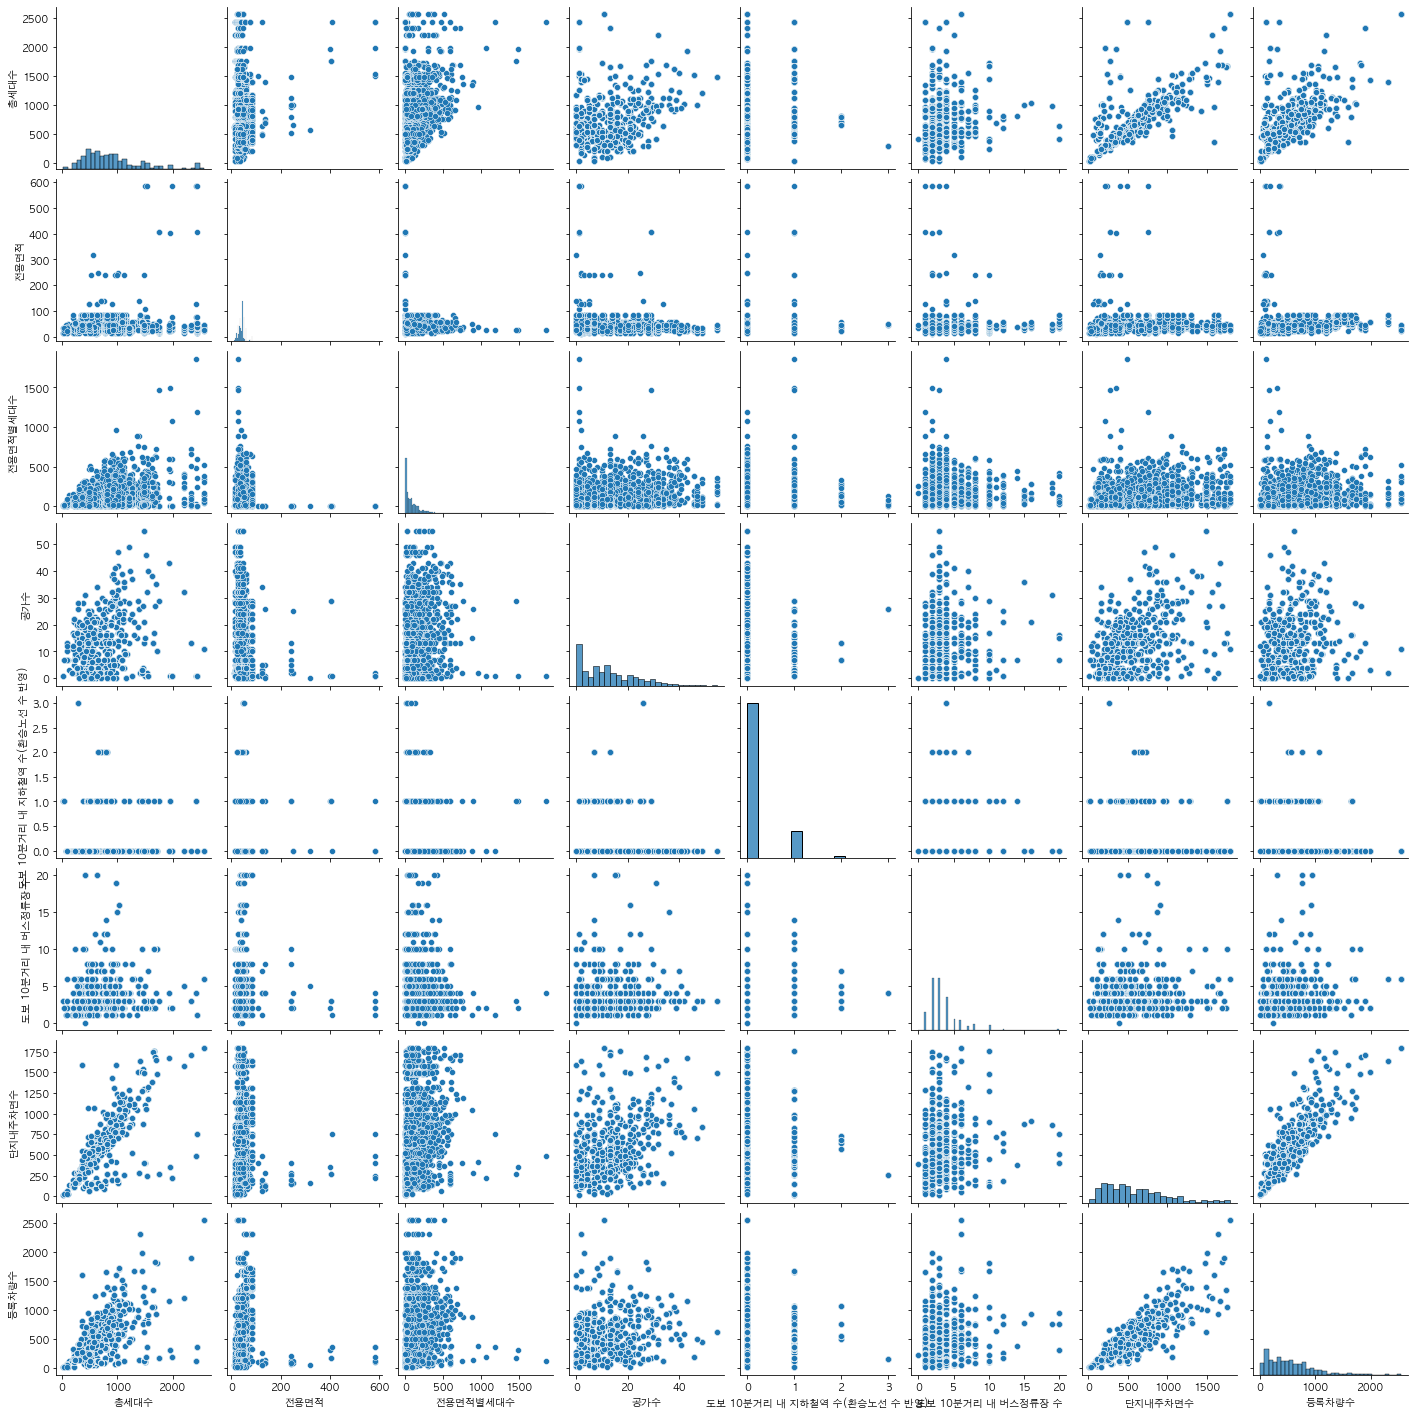

In [ ]:
sns.pairplot(train)

#### 공급유형 & 자격유형 관계

In [ ]:
pd.crosstab(train['공급유형'], train['자격유형'] , margins = True).style.background_gradient(cmap = 'coolwarm')

자격유형,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,All
공급유형,,,,,,,,,,,,,,,,
공공분양,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,7
공공임대(10년),205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,205
공공임대(50년),31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31
공공임대(5년),3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
공공임대(분납),12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12
국민임대,1539,21,0,0,34,0,9,155,0,0,0,0,0,0,0,1758
영구임대,2,0,95,0,3,3,0,0,49,0,0,0,0,0,0,152
임대상가,0,0,0,562,0,0,0,0,0,0,0,0,0,0,0,562
장기전세,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9


<br>

### 오류 확인

1. 전용면적별 세대수 합계와 총세대수가 일치하지 않는 경우  

 - (오류 내용) 제공한 데이터(트레인 및 테스트) 중 총 58개 단지에서 전용면적별 세대수 합계가 총세대수보다 적은 경우가 발생하였습니다. 

 - (분포 현황) 차이는 최소 1세대부터 최대 452세대까지이며, 그 가운데 48개 단지(83%) 는 차이가 1~14세대, 나머지 10개 단지(17%) 는 차이가 94~452세대 사이에 분포합니다. 

 - (발생 원인) 차이는 분양상가 또는 분양아파트가 임대단지 안에 혼합되어 발생한 것으로, 분양 완료된 상가 ․ 아파트는 관리대상에서 제외되어 전용면적별 세대수에서는 포함되지 않았으나 총세대수에는 포함되었습니다. 

 - (관련 데이터) 차이가 14세대 이하인 48개 단지는 분양상가, 차이가 94~452세대에 분포하는 10개 단지는 분양아파트 혼합단지인 것으로 확인되며, 아래 10개 단지의 코드를 확인하셔서 데이터 분석에 참고해주시기 바랍니다.

※ 차이가 14세대 이하인 48개 단지 : 하단 별첨 참조
['C1925', 'C1312', 'C2013', 'C1424', 'C2520', 'C2319', 'C1850', 'C1068', 'C2644', 'C2156', C2453', 'C1910', 'C2139', 'C2508', 'C1695', 'C2556', 'C2362', 'C2568', 'C2245', 'C2549', 'C1584', 'C2298', 'C2225', 'C1218', 'C1970', C1732', 'C2433', 'C1894', 'C1156', 'C2142', 'C2186', 'C2411', 'C1812', 'C1030', 'C1749', 'C1349', 'C2043', 'C1229', 'C2363', 'C1414', C2174', 'C2404', 'C1683', 'C1038', 'C2456', 'C1266', 'C1267', 'C2189']

※ 차이가 94~452세대인 10개 단지(크기순) : ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804’]

2. 동일한 단지에 단지코드가 2개로 부여된 경우  

 - (오류 내용) 동일한 단지임에도 불구하고 코드가 2개로 부여되어 별개의 단지로 인식되도록 데이터가 제공되었고, 그로 인해 주차면수는 2개 단지에 합산값으로 기재되었고 총세대수는 2개 단지에 각각 계상된 형태로 나타났습니다.

 - (발생 원인) 1번과 마찬가지로 분양과 임대가 혼합된 유형의 단지임으로 인해 발생한 오류이나 1번에서는 분양세대에 단지코드가 부여되지 않고 전용면적별 세대수에서 빠져있는 반면, 2번에서는 분양세대에도 단지코드가 부여되어 별개의 단지인 것처럼 인식되었습니다. 

 - (참고 사항) 주차면수는 하나의 단지임을 전제로 산정된 것이고 총세대수는 두 개 단지의 합계입니다. 다만 등록차량대수는 ['C2085', 'C1397'] 단지의 경우 동일 수치, ['C2431', 'C1649']] 단지의 경우 두 개 단지 합계입니다. 
 ![image.png](image/다운로드.png)



 - (관련 데이터) 아래와 같이 총 3개 단지 6개 코드에서 같은 유형의 오류가 확인되었습니다.  

※ 동일한 단지에 코드가 2개로 부여된 단지 코드 (3쌍) : ['C2085', 'C1397'], ['C2431', 'C1649'], ['C1036', 'C2675'] 

 - C2675 단지는 테스트셋, 나머지는 트레인셋 입니다.

 

3. 단지코드 등 기입 실수로 데이터 정제 과정에서 매칭 오류 발생  

 - (오류 내용) 단지코드 등 기입 실수로 총세대수가 주차면수에 비해 과하게 많거나 적은 경우가 발생하였고, 점검 결과 일부 데이터의 단지코드, 총세대수, 주차면수 등에서 오류가 검출되었습니다.

 - (발생 원인) 원천데이터 수집 과정에서 단지 코드 등이 잘못 기입되었고 이를 인지하지 못한 채 데이터 정제를 하여 오류가 발생하였습니다.

 - (관련 데이터) 아래와 같이 총 9개 단지에서 같은 문제가 확인되었습니다. 

※ 실수가 발생한 단지 코드 (9개 단지) : ['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']

 - C2335, C1327 단지는 테스트셋, 나머지는 트레인셋 입니다.




4. 오류 데이터 처리 방안

 - 제공한 데이터상에 문제점이 발견되었으나 대회 중반에 들어선 시점에서 오류를 수정하여 재배포할 경우 혼란이 가중될 것이 우려되어 데이터 수정/재배포는 없을 예정입니다.

 - 1번 오류의 경우 해당 사실을 감안하여 분석을 진행해 주시기 바라며, 2, 3번 오류의 경우에는 문제가 된 단지들을 트레인셋에서 제외하기를 권장드리고, 테스트셋에서는 평가 시 제외하고자 합니다.

 - 테스트셋에서 평가 제외되는 데이터는 'C2675'(2번 사항에 해당), 'C2335', 'C1327'(3번 사항에 해당) 3개 단지입니다.

 - 제출 양식은 변경되지 않으니 기존 제출 양식에 따라 제출 부탁드립니다.('C2675', 'C2335', 'C1327' 단지 예측 결과는 평가되지 않습니다.)

 - 이번에 검출된 오류 외 혹시 모를 추가적인 오류발생을 대비해 데이터 검증을 계속 진행중이며 문제 발견시 공지 및 안내해드리겠습니다.

### 결측치 확인

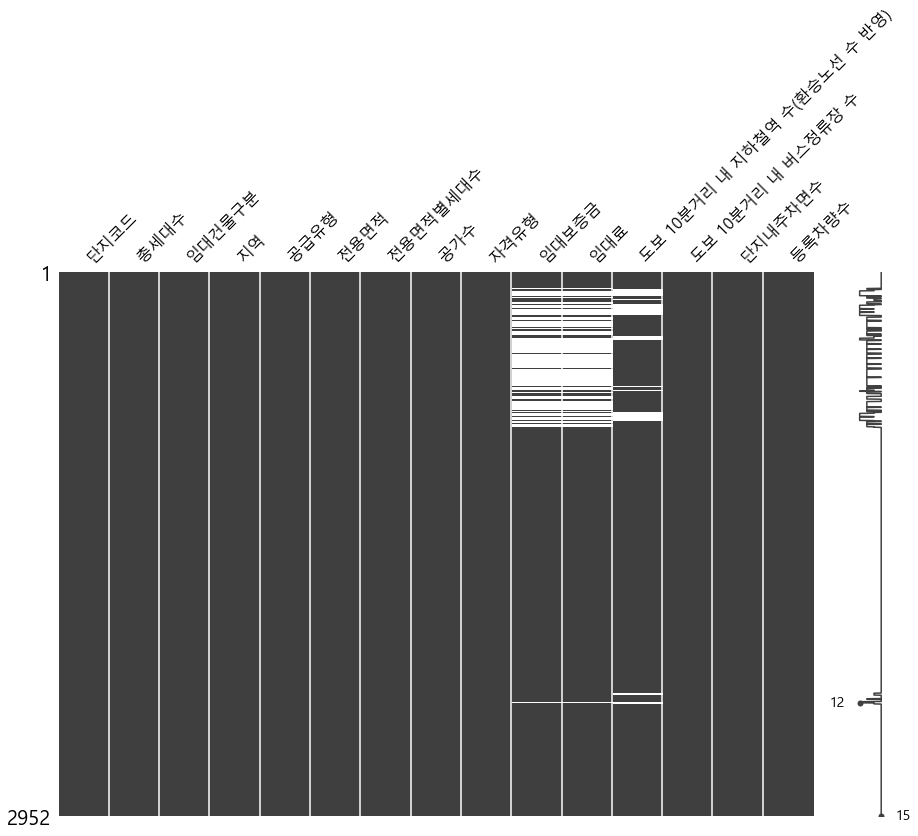

In [ ]:
msno.matrix(train, figsize=(15,10))

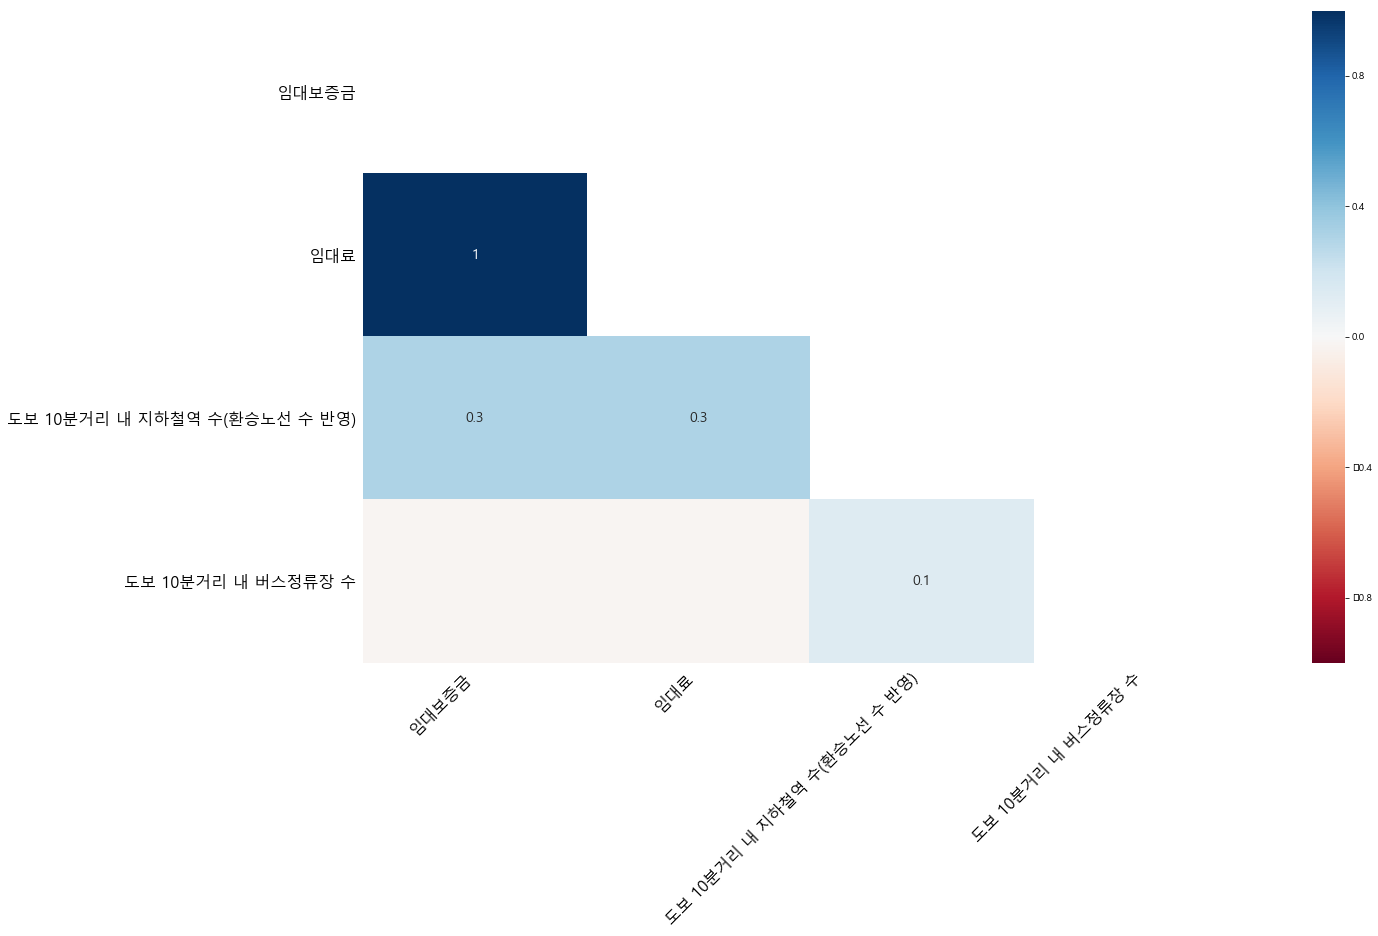

In [ ]:
msno.heatmap(train)

<br>

## 데이터 전처리

In [ ]:
# 고정된 공급 & 자격 유형 카테고리 리스트
def add_new_type(df):
    df['공급_자격_유형'] = df['공급유형'] + df['자격유형']
    return df

train = add_new_type(train)
type_lists = list(train['공급_자격_유형'].unique()) # train, test data에 모두 사용

In [ ]:
# 공급&자격 유형 카테고리로 새로운 열 추가하여 해당 조건에 속하는 row수 계산
def add_type_column_all(df, type_lists, train_yn=True):
    
    unique_cols = ['총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수']
    if train_yn == False: # test data에는 label 컬럼이 없음
        unique_cols.pop()
        
    df_temp0 = df.set_index('단지코드')[unique_cols].drop_duplicates()
    
    for type_ in type_lists:
        df_temp0[type_] = 0

    for code in df_temp0.index:
        for type_ in type_lists:
            df_temp0[type_][code] = len(df[(df['공급_자격_유형']==type_) & (df['단지코드']==code)])
            
    df_temp0.reset_index(inplace=True)
    
    df = pd.merge(df, df_temp0[type_lists], left_on=df['단지코드'], right_on=df_temp0['단지코드'], how='left')
    
    del df['key_0']

    return df

In [ ]:
def Preprocess1(df):
    
    del df['자격유형']
    del df['공급유형']
    del df['공급_자격_유형']
    
    # 2번 error 관련 data 제외
    df = df[~df['단지코드'].isin(['C2085', 'C1397','C2431', 'C1649','C1036'])]
    
    # 3번 error 관련 data 제외
    df = df[~df['단지코드'].isin(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])]
    df = df.reset_index()
    del df['index']
    
    # 1번 error
    # 총세대수와 전용면적별 세대수의 합이 다른경우, 그 차이를 총세대수 기준으로 가중치(전용면적별세대수)를 더해줌
    df_temp = df[['단지코드','전용면적별세대수']].groupby(['단지코드'],as_index=False).sum()
    df_temp.columns = ['단지코드','총세대수(new)']
    df = pd.merge(df, df_temp, on='단지코드', how='left')
    df['총세대수 차이'] = df['총세대수'] - df['총세대수(new)']
    df['전용면적별세대수'] = round(df['전용면적별세대수'] + (df['전용면적별세대수'] / df['총세대수(new)']) * df['총세대수 차이'], 3)
    
    del df['총세대수(new)']
    del df['총세대수 차이']
    
    # 임대보증금 null값 중 '-' 표기내용을 null로 변경 및 
    # 임대료 기준 null인경우 임대료 (YN) Column으로 추가 (1: 값 존재, 0: Null)
    df['임대보증금'] = df['임대보증금'].replace('-',np.nan).astype('float')
    df['임대료'] = df['임대료'].replace('-',np.nan).astype('float')
    df['임대료(YN)']=1
    df.loc[df['임대료'].isna(),'임대료(YN)']=0
    
    ## 단지코드가 단일값을 갖도록 하나의 열로 합치기

    df['총면적'] = df['전용면적'] * df['전용면적별세대수']
    df['총임대보증금'] = df['임대보증금'] * df['전용면적별세대수']
    df['총임대료'] = df['임대료'] * df['전용면적별세대수']
    
    del df['전용면적']
    
    # 총면적 -> 평균면적으로 변경하여 동일 단지코드의 경우 동일값을 갖도록 정정
    df_temp = df[['단지코드','총세대수','전용면적별세대수','총면적']]
    df_temp = df_temp.groupby(by=['단지코드','총세대수'], sort=False, as_index=False).sum()
    df_temp['평균면적'] = df_temp['총면적'] / df_temp['총세대수']
    
    del df_temp['총세대수']
    del df_temp['전용면적별세대수']
    del df_temp['총면적']
    
    df = pd.merge(df, df_temp, on='단지코드', how='left')
    
    # 위와 동일. features : 임대보증금, 임대료
    df_temp = df[['단지코드','총세대수','전용면적별세대수','총임대보증금','총임대료','임대료(YN)']]
    df_temp = df_temp.groupby(by=['단지코드','총세대수','임대료(YN)'], sort=False, as_index=False).sum()
    df_temp = df_temp[df_temp['임대료(YN)'] == 1]
    df_temp['평균임대보증금'] = df_temp['총임대보증금'] / df_temp['총세대수']
    df_temp['평균임대료'] = df_temp['총임대료'] / df_temp['총세대수']
    df_temp = df_temp[['단지코드','평균임대보증금','평균임대료']]
    df = pd.merge(df, df_temp, on='단지코드', how='left')
    
    del df['임대료(YN)']
    del df['임대료']
    del df['임대보증금']
    del df['총면적']
    del df['총임대료']
    del df['총임대보증금']
    del df['전용면적별세대수']
    
    # 동일 단지코드를 가진 모든 feature가 동일한 값을 가지게 되었으므로 중복행 제거
    df = df.drop_duplicates()
    
    # row에 해당되지 않는 경우는 전부 임대보증금과 임대료가 없는 상황이므로 null->0으로 정정
    df['평균임대보증금'] = df['평균임대보증금'].replace(np.nan,0).astype('float')
    df['평균임대료'] = df['평균임대료'].replace(np.nan,0).astype('float')
    

    # 지하철역 수 없는 경우 null값을 가지므로, fillna 0
    df['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0, inplace=True)
    
    return df

### Train Data

In [ ]:
train = add_type_column_all(train, type_lists)
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,영구임대I,공공분양D,영구임대A,행복주택J,행복주택K,행복주택L,공공임대(5년)A,행복주택M,행복주택N,행복주택O
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,...,0,0,0,0,0,0,0,0,0,0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,...,0,0,0,0,0,0,0,0,0,0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,...,0,0,0,0,0,0,0,0,0,0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,...,0,0,0,0,0,0,0,0,0,0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train = Preprocess1(train) 

In [ ]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,국민임대A,...,행복주택J,행복주택K,행복주택L,공공임대(5년)A,행복주택M,행복주택N,행복주택O,평균면적,평균임대보증금,평균임대료
0,C2515,545,아파트,경상남도,17.0,0.0,3.0,624.0,205.0,7,...,0,0,0,0,0,0,0,40.260220,1.403597e+07,119431.266055
7,C1407,1216,아파트,대전광역시,13.0,1.0,1.0,1285.0,1064.0,11,...,0,0,0,0,0,0,0,40.426875,2.760498e+07,171132.236842
18,C1945,755,아파트,경기도,6.0,1.0,3.0,734.0,730.0,0,...,0,0,0,0,0,0,0,50.280993,2.244915e+07,187414.211921
24,C1470,696,아파트,전라북도,14.0,0.0,2.0,645.0,553.0,4,...,0,0,0,0,0,0,0,44.900690,1.939399e+07,125449.224138
28,C1898,566,아파트,전라북도,9.0,0.0,6.0,517.0,415.0,6,...,0,0,0,0,0,0,0,42.710318,1.757307e+07,119608.038869


#### 결측치 확인

In [ ]:
train.isnull().sum()

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공가수                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
등록차량수                           0
국민임대A                           0
국민임대B                           0
공공임대(50년)A                      0
영구임대C                           0
임대상가D                           0
영구임대E                           0
영구임대F                           0
국민임대E                           0
국민임대G                           0
국민임대H                           0
공공임대(10년)A                      0
공공임대(분납)A                       0
장기전세A                           0
영구임대I                           0
공공분양D                           0
영구임대A                           0
행복주택J                           0
행복주택K                           0
행복주택L                           0
공공임대(5년)A                       0
행복주택M         

<br>

### Test Data

In [ ]:
test = add_new_type(test)
test = add_type_column_all(test, type_lists, False)
test = Preprocess1(test)
test.head()

,단지코드,총세대수,임대건물구분,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,국민임대A,국민임대B,...,행복주택J,행복주택K,행복주택L,공공임대(5년)A,행복주택M,행복주택N,행복주택O,평균면적,평균임대보증금,평균임대료
0,C1072,754,아파트,경기도,14.0,0.0,2.0,683.0,1,0,...,0,0,0,0,0,0,0,48.269164,3.772908e+07,264048.249337
8,C1128,1354,아파트,경기도,9.0,0.0,3.0,1216.0,4,0,...,0,0,0,0,0,0,0,46.846145,3.512774e+07,251290.044313
17,C1456,619,아파트,부산광역시,18.0,0.0,16.0,547.0,9,0,...,0,0,0,0,0,0,0,45.167690,3.422472e+07,224706.187399
26,C1840,593,아파트,전라북도,7.0,0.0,3.0,543.0,4,0,...,0,0,0,0,0,0,0,43.471619,1.806555e+07,120287.537943
30,C1332,1297,아파트,경기도,11.0,0.0,2.0,1112.0,0,0,...,0,0,0,0,0,0,0,45.841735,4.010183e+07,284193.623747


#### 결측치 확인

In [ ]:
test.isnull().sum()

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공가수                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
국민임대A                           0
국민임대B                           0
공공임대(50년)A                      0
영구임대C                           0
임대상가D                           0
영구임대E                           0
영구임대F                           0
국민임대E                           0
국민임대G                           0
국민임대H                           0
공공임대(10년)A                      0
공공임대(분납)A                       0
장기전세A                           0
영구임대I                           0
공공분양D                           0
영구임대A                           0
행복주택J                           0
행복주택K                           0
행복주택L                           0
공공임대(5년)A                       0
행복주택M                           0
행복주택N         

## csv 저장 & 불러오기

In [ ]:
# # data save
# train.to_csv('data/train_preprocessing.csv',encoding = 'utf-8')
# test.to_csv('data/test_preprocessing.csv',encoding = 'utf-8')

In [ ]:
# data load
train = pd.read_csv('data/train_preprocessing.csv',encoding = 'utf-8')
test = pd.read_csv('data/test_preprocessing.csv',encoding = 'utf-8')

In [ ]:
train = train.iloc[:,1:]
test = test.iloc[:,1:]

<br>

## 추가 자료

### 2020년 12월 자동차 등록자료 통계.xlsx

https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1257

지역별 인구수와 자동차 등록 통계자료 이용하여 지역 점수 부과

In [ ]:
# 추가자료 - 2020년 12월 자동차 등록 통계자료
car = pd.read_excel('data/자동차_등록자료_통계.xlsx', index_col='구분')
car = car.iloc[:,:16]
car.head()

,서울특별시,부산광역시,대구광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
구분,,,,,,,,,,,,,,,,
10대미만(남자),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10대(남자),1425,460,252,176,325,214,75,2276,200,305,300,329,318,229,605,172
20대(남자),42173,21591,20388,14679,14197,10502,2571,115366,16530,19138,23913,16294,17681,23871,28480,6056
30대(남자),327305,126511,109968,68522,70470,57988,24215,666598,67700,81548,119808,72617,76968,121652,156605,30122
40대(남자),513225,211371,194187,119197,115912,100776,41146,1105256,122526,134630,198306,147007,149452,227657,290589,61691


In [ ]:
# dacon 제공자료 - 지역별 & 성별 & 연령별 인구 데이터
age = pd.read_csv('data/age_gender_info.csv', encoding='utf-8',index_col = '지역')
age.head()

,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
지역,,,,,,,,,,,,,,,,,,,,,
경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,...,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,...,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


In [ ]:
temp_lst = set()

for x in car.columns:
    temp_lst.add(x)
    
temp_lst = list(temp_lst)
temp_lst.sort()

# age dataframe을 오름차순 정렬(강원도,경기도, 경상남도,...순) 하고, car dataframe과 동일 행,렬 간 곱셈처리
np.score = np.array(age.sort_index()) * np.array(car.transpose().sort_index())

df_score = pd.DataFrame(np.score)
df_score['지역'] = temp_lst

# 지역, 연령별 점수를 지역을 기준으로 전부 더해줌.
df_score['지역점수'] = df_score.transpose().iloc[:22,:].sum().transpose()

In [ ]:
df_score[['지역', '지역점수', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]].head()

,지역,지역점수,0,1,2,3,4,5,6,7,8,9
0,강원도,39002.359527,0.0,6.136306,847.770475,3568.594182,7397.369872,9946.471557,8153.249392,2236.683712,644.506832,37.945310
1,경기도,283421.383725,0.0,89.918461,6062.001568,35989.495367,64639.537128,67076.541863,52536.391090,13044.629166,2808.260173,225.504806
2,경상남도,84581.674602,0.0,16.275946,1516.758566,8702.184213,18865.130498,24196.531673,14655.487171,4199.754263,791.114343,57.054064
3,경상북도,71541.592460,0.0,7.601555,1345.025226,7464.625421,13681.377767,20720.687138,13775.405136,4212.530728,1108.824945,68.764615
4,광주광역시,33314.619670,0.0,6.083660,731.756397,3443.511987,7757.868734,8617.935080,5314.768932,1563.764178,280.499010,26.605597


In [ ]:
# train,test data에 지역과 1대1 매칭되는 지역점수 column을 생성
df_score = df_score[['지역', '지역점수']]

train = pd.merge(train, df_score, how='left', on='지역')
test = pd.merge(test, df_score, how='left', on='지역')

In [ ]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,국민임대A,...,행복주택K,행복주택L,공공임대(5년)A,행복주택M,행복주택N,행복주택O,평균면적,평균임대보증금,평균임대료,지역점수
0,C2515,545,아파트,경상남도,17.0,0.0,3.0,624.0,205.0,0,...,0,0,0,0,0,0,40.260220,1.403597e+07,119431.266055,84581.674602
1,C1407,1216,아파트,대전광역시,13.0,1.0,1.0,1285.0,1064.0,0,...,0,0,0,0,0,0,40.426875,2.760498e+07,171132.236842,33108.648680
2,C1945,755,아파트,경기도,6.0,1.0,3.0,734.0,730.0,0,...,0,0,0,0,0,0,50.280993,2.244915e+07,187414.211921,283421.383725
3,C1470,696,아파트,전라북도,14.0,0.0,2.0,645.0,553.0,0,...,0,0,0,0,0,0,44.900690,1.939399e+07,125449.224138,45983.556778
4,C1898,566,아파트,전라북도,9.0,0.0,6.0,517.0,415.0,0,...,0,0,0,0,0,0,42.710318,1.757307e+07,119608.038869,45983.556778


In [ ]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,국민임대A,국민임대B,...,행복주택K,행복주택L,공공임대(5년)A,행복주택M,행복주택N,행복주택O,평균면적,평균임대보증금,평균임대료,지역점수
0,C1072,754,아파트,경기도,14.0,0.0,2.0,683.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,48.269164,3.772908e+07,264048.249337,283421.383725
1,C1128,1354,아파트,경기도,9.0,0.0,3.0,1216.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,46.846145,3.512774e+07,251290.044313,283421.383725
2,C1456,619,아파트,부산광역시,18.0,0.0,16.0,547.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45.167690,3.422472e+07,224706.187399,56417.318693
3,C1840,593,아파트,전라북도,7.0,0.0,3.0,543.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,43.471619,1.806555e+07,120287.537943,45983.556778
4,C1332,1297,아파트,경기도,11.0,0.0,2.0,1112.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,45.841735,4.010183e+07,284193.623747,283421.383725


<br>

# Machine Learning

In [ ]:
# x_train = train.iloc[:, 1:]
# x_test = test.iloc[:, 1:]

## Pipeline

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# Feature dtype별 정리

# numeric
numeric_features = ['총세대수', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '평균면적', '평균임대보증금', '평균임대료', '국민임대A',
       '국민임대B', '공공임대(50년)A', '영구임대C', '임대상가D', '영구임대E', '영구임대F', '국민임대E',
       '국민임대G', '국민임대H', '공공임대(10년)A', '공공임대(분납)A', '장기전세A', '영구임대I', '공공분양D',
       '영구임대A', '행복주택J', '행복주택K', '행복주택L', '공공임대(5년)A', '행복주택M', '행복주택N',
       '행복주택O', '지역점수']

numeric_transformer = StandardScaler()

# categorical
categorical_features = ['임대건물구분', '지역']

categorical_transformer = OneHotEncoder(categories='auto',sparse = False)

In [ ]:
# 전처리용 transformer 만들고, pipeline 생성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])
preprocessor_pipe.fit(train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', StandardScaler(copy=True, with_mean=True, with_std=True), ['총세대수', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수', ...'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False), ['임대건물구분', '지역'])]))])

In [ ]:
preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)

array(['임대건물구분_상가', '임대건물구분_아파트', '지역_강원도', '지역_경기도', '지역_경상남도',
       '지역_경상북도', '지역_광주광역시', '지역_대구광역시', '지역_대전광역시', '지역_부산광역시',
       '지역_서울특별시', '지역_세종특별자치시', '지역_울산광역시', '지역_전라남도', '지역_전라북도',
       '지역_제주특별자치도', '지역_충청남도', '지역_충청북도'], dtype=object)

In [ ]:
# Coumn명 살리기
feature_names_arr = np.array(numeric_features)
feature_names_arr = np.append(feature_names_arr, preprocessor.named_transformers_['cat'].get_feature_names(categorical_features) )

In [ ]:
# train, test data pipeline 통과
x_train = pd.DataFrame(preprocessor_pipe.transform(train), columns = feature_names_arr)

In [ ]:
x_test = pd.DataFrame(preprocessor_pipe.transform(test), columns = feature_names_arr)

In [ ]:
x_train['단지코드'] = train['단지코드']
x_train['등록차량수'] = train['등록차량수']
x_test['단지코드'] = test['단지코드']

In [ ]:
x_train.columns

Index(['총세대수', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '평균면적', '평균임대보증금', '평균임대료', '국민임대A', '국민임대B', '공공임대(50년)A',
       '영구임대C', '임대상가D', '영구임대E', '영구임대F', '국민임대E', '국민임대G', '국민임대H',
       '공공임대(10년)A', '공공임대(분납)A', '장기전세A', '영구임대I', '공공분양D', '영구임대A', '행복주택J',
       '행복주택K', '행복주택L', '공공임대(5년)A', '행복주택M', '행복주택N', '행복주택O', '지역점수',
       '임대건물구분_상가', '임대건물구분_아파트', '지역_강원도', '지역_경기도', '지역_경상남도', '지역_경상북도',
       '지역_광주광역시', '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시',
       '지역_세종특별자치시', '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도',
       '지역_충청북도', '단지코드', '등록차량수'],
      dtype='object')

In [ ]:
x_train = x_train.groupby(['단지코드','총세대수', '공가수', '평균면적', '평균임대보증금', '평균임대료',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '지역점수','등록차량수'],as_index=False).sum()

In [ ]:
x_test = x_test.groupby(['단지코드','총세대수', '공가수', '평균면적', '평균임대보증금', '평균임대료',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '지역점수'],as_index=False).sum()

In [ ]:
y_train = x_train[['단지코드','등록차량수']]

In [ ]:
del x_train['등록차량수']

In [ ]:
x_train = x_train.set_index('단지코드')
y_train = y_train.set_index('단지코드')
x_test = x_test.set_index('단지코드')

In [ ]:
# # data save
# x_train = pd.to_csv('data/x_train.csv',encoding='euc-kr')
# y_train = pd.to_csv('data/y_train.csv',encoding='euc-kr')
# x_test = pd.to_csv('data/x_test.csv',encoding='euc-kr')

### x,y data load (pipeline 완료data)

In [2]:
### data load
x_train = pd.read_csv('data/x_train.csv',encoding='euc-kr',index_col='단지코드')
y_train = pd.read_csv('data/y_train.csv',encoding='euc-kr',index_col='단지코드')
x_test = pd.read_csv('data/x_test.csv',encoding='euc-kr',index_col='단지코드')

<br>

## Train / Test Split

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# y_test data가 없으므로, x_train, y_train에서 30%씩을 test data로 활용
xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

<br>

## Machine Learning

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

### default modeling

#### LinearRegression

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
line_reg = LinearRegression()
line_reg.fit(xx_train, yy_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [8]:
print("MAE(train):", round(mean_absolute_error(yy_train,line_reg.predict(xx_train) ), 4))
print("MSE(train):", round(mean_squared_error(yy_train,line_reg.predict(xx_train) ), 4))

MAE(train): 115.7987
MSE(train): 24908.3854


In [9]:
print("MAE:", round(mean_absolute_error(yy_test,line_reg.predict(xx_test) ), 4))
print("MSE:", round(mean_squared_error(yy_test,line_reg.predict(xx_test) ), 4))

MAE: 118.9176
MSE: 35614.0335


#### XGB boost

In [10]:
from xgboost import XGBRegressor

In [11]:
XGB_reg = XGBRegressor(random_state=0)
XGB_reg.fit(xx_train, yy_train)

print("default_XGB_MAE:", round(mean_absolute_error(yy_test,XGB_reg.predict(xx_test) ), 4))
print("default_XGB_MSE:", round(mean_squared_error(yy_test,XGB_reg.predict(xx_test) ), 4))

default_XGB_MAE: 131.9592
default_XGB_MSE: 44804.9033


#### CAT boost
내용 : https://dailyheumsi.tistory.com/136

In [12]:
# !pip install catboost
from catboost import CatBoostRegressor

In [1]:
CAT_reg = CatBoostRegressor(
         loss_function='MAE',
         random_state=0
    )
CAT_reg.fit(xx_train,yy_train)

In [14]:
print("default_CAT_MAE:", round(mean_absolute_error(yy_test,CAT_reg.predict(xx_test) ), 4))
print("default_CAT_MSE:", round(mean_squared_error(yy_test,CAT_reg.predict(xx_test) ), 4))

default_CAT_MAE: 120.3762
default_CAT_MSE: 40605.0281


#### NG boost
https://github.com/stanfordmlgroup/ngboost <br>
NG boost는 일반 ML과 다르게, 예측의 불확실성까지 예측함.
- ex) 이 집의 가격은 5억일 확률이 75%다.

In [15]:
# !pip install ngboost
from ngboost import NGBRegressor

In [16]:
NGB_reg = NGBRegressor()
NGB_reg.fit(xx_train, yy_train)

print("default_NGB_MAE:", round(mean_absolute_error(yy_test,NGB_reg.predict(xx_test) ), 4))
print("default_NGB_MSE:", round(mean_squared_error(yy_test,NGB_reg.predict(xx_test) ), 4))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=7.3035 val_loss=0.0000 scale=1.0000 norm=276.5511
[iter 100] loss=6.6062 val_loss=0.0000 scale=2.0000 norm=258.5052
[iter 200] loss=6.0820 val_loss=0.0000 scale=2.0000 norm=169.2865
[iter 300] loss=5.8367 val_loss=0.0000 scale=1.0000 norm=73.2189
[iter 400] loss=5.6993 val_loss=0.0000 scale=1.0000 norm=66.8866
default_NGB_MAE: 129.4785
default_NGB_MSE: 49780.9118


#### SVM

In [17]:
from sklearn.svm import SVR

In [18]:
SVM_reg = SVR()
SVM_reg.fit(xx_train, yy_train)
print("MAE:", round(mean_absolute_error(yy_test,SVM_reg.predict(xx_test) ), 4))
print("MSE:", round(mean_squared_error(yy_test,SVM_reg.predict(xx_test) ), 4))

MAE: 308.1292
MSE: 198126.108


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### AutoML with Hyperopt (CATboost, XGboost, NGboost)
https://teddylee777.github.io/thoughts/hyper-opt <br>
http://hyperopt.github.io/hyperopt/

#### Load model

In [ ]:
from sklearn.externals import joblib

In [ ]:
# CAT_fitted_model = joblib.load('CAT_fitted_model.pkl')
# XGB_fitted_model = joblib.load('XGB_fitted_model.pkl')
# NGB_fitted_model = joblib.load('NGB_fitted_model.pkl')

#### 기본 setting

In [ ]:
# !pip install hyperopt
# 0.2.5 ver

In [ ]:
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
random_state = 0
kf = KFold(n_splits=10, random_state=0)

In [ ]:
def gb_mae_cv_CAT(params, random_state=0, cv=kf, x = xx_train, y= yy_train) :
    params = {'n_estimators': int(params['n_estimators']), 
             'learning_rate': params['learning_rate']}
    
    CAT_HPO = CatBoostRegressor(random_state=random_state,**params)
    CAT_score = -cross_val_score(CAT_HPO, x, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    return CAT_score

def gb_mae_cv_XGB(params, random_state=0, cv=kf, x = xx_train, y= yy_train) :
    params = {'n_estimators': int(params['n_estimators']), 
             'learning_rate': params['learning_rate']}

    XGB_HPO = XGBRegressor(random_state=random_state,**params)
    XGB_score = -cross_val_score(XGB_HPO, x, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    return XGB_score

def gb_mae_cv_NGB(params, random_state=0, cv=kf, x = xx_train, y= yy_train) :
    params = {'n_estimators': int(params['n_estimators']), 
             'learning_rate': params['learning_rate']}

    NGB_HPO = NGBRegressor(random_state=random_state,**params)
    NGB_score = -cross_val_score(NGB_HPO, x, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    return NGB_score

In [ ]:
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0) #q uniform이 아니라 loguniform을 쓰는건, 등비척도로 움직이기 위해서
      }
space_XGB={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
           'max_depth' : hp.quniform('max_depth', 1,20,1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0) #q uniform이 아니라 loguniform을 쓰는건, 등비척도로 움직이기 위해서
      }

trials_CAT = Trials()
trials_XGB = Trials()
trials_NGB = Trials()

#### CAT Boost

In [ ]:
best_CAT=fmin(fn=gb_mae_cv_CAT, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
                              #Tree of Parzen Estimators (TPE) 
                              #http://hyperopt.github.io/hyperopt/
          max_evals=50, # maximum number of iterations
          trials=trials_CAT, # logging
          rstate=np.random.RandomState(0) # fixing random state for the reproducibility
         )

In [ ]:
CAT_best_reg = CatBoostRegressor(learning_rate = best_CAT['learning_rate']
                             ,n_estimators = int(best_CAT['n_estimators']))

CAT_fitted_model = CAT_best_reg.fit(xx_train, yy_train)

print("=============================================================")
print("CAT_HPO_MAE:", round(mean_absolute_error(yy_test,CAT_best_reg.predict(xx_test) ), 4))
print("CAT_HPO_MSE:", round(mean_squared_error(yy_test,CAT_best_reg.predict(xx_test) ), 4))

In [ ]:
joblib.dump(CAT_fitted_model, 'CAT_fitted_model.pkl', compress =True)

In [ ]:
tpe_results_CAT=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials_CAT.trials])

tpe_results_CAT_df=pd.DataFrame(tpe_results_CAT,
                           columns=['score', 'learning_rate', 'n_estimators'])
tpe_results_CAT_df.plot(subplots=True,figsize=(10, 10))

#### XGBoost

In [ ]:
best_XGB=fmin(fn=gb_mae_cv_XGB,
          space=space_XGB, 
          algo=tpe.suggest,
          max_evals=50,
          trials=trials_XGB,
          rstate=np.random.RandomState(0)
         )

In [ ]:
XGB_best_reg = XGBRegressor(learning_rate = best_XGB['learning_rate']
                            ,max_depth = int(best_XGB['max_depth'])
                             ,n_estimators = int(best_XGB['n_estimators']))

XGB_fitted_model = XGB_best_reg.fit(xx_train, yy_train)
ss
print("=============================================================")
print("XGB_HPO_MAE:", round(mean_absolute_error(yy_test,XGB_best_reg.predict(xx_test) ), 4))
print("XGB_HPO_MSE:", round(mean_squared_error(yy_test,XGB_best_reg.predict(xx_test) ), 4))

In [ ]:
joblib.dump(XGB_fitted_model, 'XGB_fitted_model.pkl', compress =True)

In [ ]:
tpe_results_XGB=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials_XGB.trials])

tpe_results_XGB_df=pd.DataFrame(tpe_results_XGB,
                           columns=['score', 'learning_rate', 'n_estimators'])
tpe_results_XGB_df.plot(subplots=True,figsize=(10, 10))

#### NGB

In [ ]:
best_NGB=fmin(fn=gb_mae_cv_NGB,
          space=space, 
          algo=tpe.suggest,
          max_evals=50,
          trials=trials_NGB,
          rstate=np.random.RandomState(0)
         )

In [ ]:
NGB_best_reg = NGBRegressor(learning_rate = best_NGB['learning_rate']
                             ,n_estimators = int(best_NGB['n_estimators']))

NGB_fitted_model=NGB_best_reg.fit(xx_train, yy_train)

print("=============================================================")
print("NGB_HPO_MAE:", round(mean_absolute_error(yy_test,NGB_best_reg.predict(xx_test) ), 4))
print("NGB_HPO_MSE:", round(mean_squared_error(yy_test,NGB_best_reg.predict(xx_test) ), 4))

In [ ]:
joblib.dump(NGB_fitted_model, 'NGB_fitted_model.pkl', compress =True)

In [ ]:
tpe_results_NGB=np.array([[
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials_NGB.trials])

tpe_results_NGB_df=pd.DataFrame(tpe_results_NGB,
                           columns=[ 'learning_rate', 'n_estimators'])
tpe_results_NGB_df.plot(subplots=True,figsize=(10, 10))

#### Summary

In [19]:
print("default_XGB_MAE:", round(mean_absolute_error(yy_test,XGB_reg.predict(xx_test) ), 4))
print("default_XGB_MSE:", round(mean_squared_error(yy_test,XGB_reg.predict(xx_test) ), 4))

print("default_CAT_MAE:", round(mean_absolute_error(yy_test,CAT_reg.predict(xx_test) ), 4))
print("default_CAT_MSE:", round(mean_squared_error(yy_test,CAT_reg.predict(xx_test) ), 4))

print("default_NGB_MAE:", round(mean_absolute_error(yy_test,NGB_reg.predict(xx_test) ), 4))
print("default_NGB_MSE:", round(mean_squared_error(yy_test,NGB_reg.predict(xx_test) ), 4))

default_XGB_MAE: 131.9592
default_XGB_MSE: 44804.9033
default_CAT_MAE: 120.3762
default_CAT_MSE: 40605.0281
default_NGB_MAE: 129.4785
default_NGB_MSE: 49780.9118


In [ ]:
print("CAT_HPO_MAE:", round(mean_absolute_error(yy_test,CAT_fitted_model.predict(xx_test) ), 4))
print("CAT_HPO_MSE:", round(mean_squared_error(yy_test,CAT_fitted_model.predict(xx_test) ), 4))

print("XGB_HPO_MAE:", round(mean_absolute_error(yy_test,XGB_fitted_model.predict(xx_test) ), 4))
print("XGB_HPO_MSE:", round(mean_squared_error(yy_test,XGB_fitted_model.predict(xx_test) ), 4))

print("NGB_HPO_MAE:", round(mean_absolute_error(yy_test,NGB_fitted_model.predict(xx_test) ), 4))
print("NGB_HPO_MSE:", round(mean_squared_error(yy_test,NGB_fitted_model.predict(xx_test) ), 4))

CAT_HPO_MAE: 114.4855
CAT_HPO_MSE: 38960.8763
XGB_HPO_MAE: 129.7256
XGB_HPO_MSE: 48924.2068
NGB_HPO_MAE: 127.0101
NGB_HPO_MSE: 48365.1558


- HPO를 진행하지 않은 NG Boost에서 가장 좋은 성능(MAE: 62.9204)이 나옴.


<br>

## Feature Importance

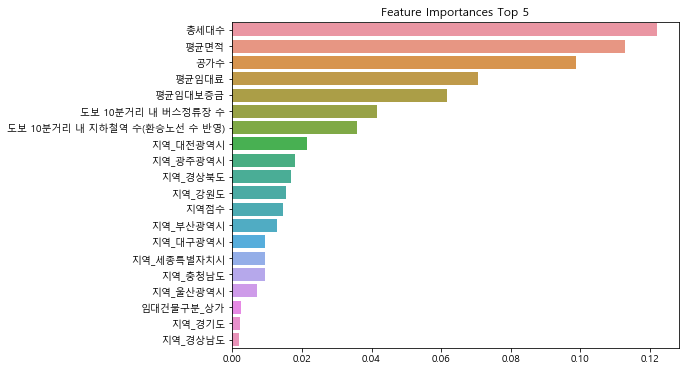

In [ ]:
import seaborn as sns
# NGB regressor는 각 row별 값과 그에대한 확률이 리스트 형식으로 묶여있어 [0]에 있는 값을 추출해야함
feature_importance_values = NGB_reg.feature_importances_[0] 

# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=xx_train.columns)
# 중요도값 순으로 Series를 정렬
feature_top20 = feature_importances.sort_values(ascending=False)[1:21]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 5')
sns.barplot(x=feature_top20, y=feature_top20.index)
plt.show()

- Feature 분석
    - 각 호실별 크고, 임대료와 보증금이 높은 경우 경제적 능력이 뒷받침이 된다고 볼 수 있음 
    - 도보 10분이내에 버스, 지하철이 많이 있는 경우에는 보통 집값이 비싸고, 이는 금전적 능력과 관계가 있음
    - 지역별로도 해당 내용이 

<br>

## Dacon 답안 제출

In [ ]:
out = pd.DataFrame(NGB_reg.predict(x_test),columns=['num']).set_index(x_test.index)
out.index.name='code'
out.to_csv('aaa.csv',encoding='euc-kr')

<br>

# Deep Learning

In [ ]:
# loss curve func
def plot_loss_curve(total_epoch=10, start=1):
    plt.figure(figsize=(15, 5))
    plt.plot(range(start, total_epoch +1), history.history['loss'][start-1:total_epoch], label='Train')
    plt.plot(range(start, total_epoch +1), history.history['val_loss'][start-1:total_epoch], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [ ]:
import os
# tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
model = models.Sequential() 

model.add(layers.Dense(input_dim=50, units=96, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
model.add(layers.Activation('relu')) # elu, relu / layers.ELU, layers.LeakyReLU

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('relu'))

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('relu'))

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('relu'))

# dropout
model.add(layers.Dropout(rate=0.4)) 

model.add(layers.Dense(units=1, activation='linear'))

In [ ]:
model.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_absolute_error, # MAE / mean_absolute_error
              metrics=[metrics.mae])

In [ ]:
history = model.fit(xx_train, yy_train, batch_size=100, epochs=1000, validation_split=0.3, verbose=0)

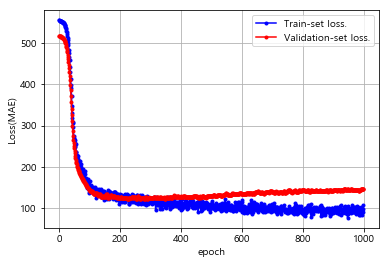

In [ ]:
loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']

x_len = np.arange(len(loss))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss(MAE)')
plt.show()

In [ ]:
model.predict(x_test)[:10]

array([[120.54285 ],
       [ 68.11222 ],
       [620.3847  ],
       [245.30782 ],
       [ 16.775167],
       [342.2208  ],
       [340.55444 ],
       [538.14056 ],
       [647.5127  ],
       [530.9666  ]], dtype=float32)

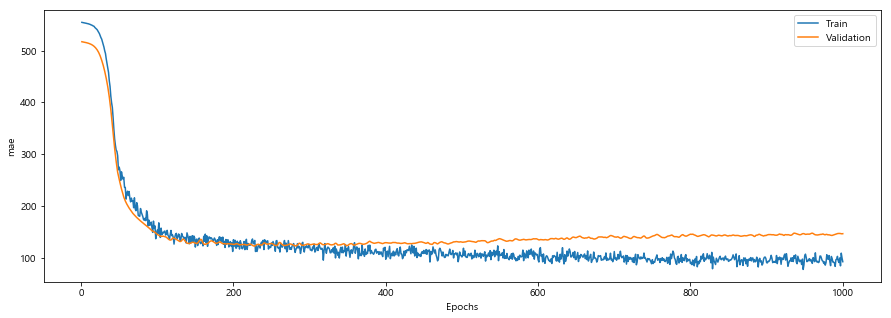

In [ ]:
plot_loss_curve(total_epoch=1000, start=1)

In [ ]:
yy_pred = model.predict(xx_train)
yy_pred[:10]

array([[ 266.63553 ],
       [ 517.4009  ],
       [ 720.5334  ],
       [ 260.2549  ],
       [1299.5933  ],
       [1407.2179  ],
       [ 145.1031  ],
       [ 161.82967 ],
       [ 227.07643 ],
       [  49.539566]], dtype=float32)

In [ ]:
model.evaluate(xx_test,yy_test)

124/124 [==============================] - 0s 138us/sample - loss: 161.2025 - mean_absolute_error: 161.2025


[161.2024910219254, 161.2025]

<br>

## 딥러닝 성능 최적화

### Activation func 변경 (for문을 통한 HPO)

######### 바로 하단 코드는 절대 돌리지 말것. #########

In [ ]:
def build_model(a,b,c,d):
    model = models.Sequential()
    model.add(layers.Dense(input_dim=xx_test.shape[1], units=32*a, activation=None, kernel_initializer=initializers.he_uniform()))
    model.add(layers.Dense(32*b, activation='relu'))
    model.add(layers.Dense(32*c, activation='relu'))
    model.add(layers.Dense(32*d, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    
    return model

In [2]:
for a in range(1,5):
    for b in range(1,5):
        for c in range(1,5):
            for d in range(1,5):
                
                # modeling
                globals()['model_{}{}{}{}'.format(a,b,c,d)]=build_model(a,b,c,d)
                # 미니 배치 학습
                globals()['model_{}{}{}{}'.format(a,b,c,d)].fit(xx_train, yy_train, epochs=200, batch_size=32, verbose=0)
                # 모델평가
                globals()['result_{}{}{}{}'.format(a,b,c,d)] = globals()['model_{}{}{}{}'.format(a,b,c,d)].evaluate(xx_test, yy_test)
                globals()['history_{}{}{}{}'.format(a,b,c,d)] = globals()['model_{}{}{}{}'.format(a,b,c,d)].fit(xx_train, yy_train, batch_size=32, epochs=200, validation_split=0.25, verbose=0) 
                print(32*a,32*b,32*c,32*d,globals()['result_{}{}{}{}'.format(a,b,c,d)][0])
                print('=================================================')
                # plot_loss_curve(total_epoch=200, start=1)


최적 조합 (hiddenlayer 수가 4인 기준)<br>
각 layer별 퍼셉트론 수 : 96 32 32 32 / 114.9000015258789



In [ ]:
best_nn_reg = build_model(3,1,1,1) # 96, 32, 32, 32개 퍼셉트론
best_nn_reg.fit(xx_train, yy_train, epochs=200, batch_size=32, verbose=0)
best_nn_reg.evaluate(xx_test,yy_test)

124/124 [==============================] - 0s 1ms/sample - loss: 124.8417 - mean_absolute_error: 124.8417


[124.84170458393712, 124.841705]

In [ ]:
print('loss(MAE) - test :', result[0])

loss(MAE) - test : 124.16610717773438


## Layer Tuning  with Keras Tuner (only colab)

In [7]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 96 kB 4.4 MB/s 


In [8]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow import keras 
from tensorflow.keras import layers
from keras import initializers

import kerastuner as kt
import numpy as np
import IPython

In [9]:
def build_hyper_model(hp):
    
    model = keras.Sequential()
    model.add(layers.Dense(input_dim=xx_train.shape[1], units=64, activation=None, kernel_initializer=initializers.he_uniform()))
        

    for i in range(hp.Int('num_layers', min_value=1, max_value=3)): 
        # Tune the number of perceptrons in a dense layer (Choose an optimal value between 32~512) 
        hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32)
        hp_activations = hp.Choice('activation_' + str(i), values=['relu', 'elu'])
        model.add(layers.Dense(units = hp_units, activation = hp_activations))

    model.add(layers.Dense(1, activation=None))

    # Tune the learning rate for the optimizer (Choose an optimal value from 0.01, 0.001, or 0.0001)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.MeanSquaredError(),
                metrics = [keras.metrics.MeanAbsoluteError()])
    
    return model

In [10]:
tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = 'val_mean_absolute_error',
                                max_trials = 10,
                                directory = 'test_prac_dir',
                                project_name = 'Parking_lot')

In [11]:
# best 3 model
tuner.search(xx_train, yy_train, epochs=10, validation_data = (xx_test, yy_test))
tuner.results_summary(num_trials=3)

Trial 10 Complete [00h 00m 01s]
val_mean_absolute_error: 116.50655364990234

Best val_mean_absolute_error So Far: 109.78351593017578
Total elapsed time: 00h 00m 41s
Results summary
Results in test_prac_dir/Parking_lot
Showing 3 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
activation_0: elu
learning_rate: 0.01
units_1: 512
activation_1: relu
units_2: 512
activation_2: relu
Score: 109.78351593017578
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
activation_0: elu
learning_rate: 0.01
units_1: 512
activation_1: relu
units_2: 32
activation_2: elu
Score: 110.49470520019531
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
activation_0: elu
learning_rate: 0.01
units_1: 160
activation_1: elu
units_2: 32
activation_2: relu
Score: 111.64348602294922


In [12]:
top3_models = tuner.get_best_hyperparameters(num_trials=3)

In [13]:
for idx, model in enumerate(top3_models):
    print('Model performance rank :', idx+1)
    print(model.values)
    print()

Model performance rank : 1
{'num_layers': 3, 'units_0': 512, 'activation_0': 'elu', 'learning_rate': 0.01, 'units_1': 512, 'activation_1': 'relu', 'units_2': 512, 'activation_2': 'relu'}

Model performance rank : 2
{'num_layers': 3, 'units_0': 512, 'activation_0': 'elu', 'learning_rate': 0.01, 'units_1': 512, 'activation_1': 'relu', 'units_2': 32, 'activation_2': 'elu'}

Model performance rank : 3
{'num_layers': 3, 'units_0': 512, 'activation_0': 'elu', 'learning_rate': 0.01, 'units_1': 160, 'activation_1': 'elu', 'units_2': 32, 'activation_2': 'relu'}



In [14]:
best_hps = top3_models[0]

In [15]:
print("""
The hyperparameter search is complete. 
* Optimal # of layers : {}
* Optimal value of the learning-rate : {}""".format(best_hps.get('num_layers'), best_hps.get('learning_rate')))

for layer_num in range(best_hps.get('num_layers')):
    print('Layer {} - # of Perceptrons :'.format(layer_num), best_hps.get('units_' + str(layer_num)))
    print('Layer {} - Applied activation function :'.format(layer_num), best_hps.get('activation_' + str(layer_num)))


The hyperparameter search is complete. 
* Optimal # of layers : 3
* Optimal value of the learning-rate : 0.01
Layer 0 - # of Perceptrons : 512
Layer 0 - Applied activation function : elu
Layer 1 - # of Perceptrons : 512
Layer 1 - Applied activation function : relu
Layer 2 - # of Perceptrons : 512
Layer 2 - Applied activation function : relu


In [16]:
models = tuner.get_best_models(num_models=3)
top_model = models[0]
top_model.summary()
print()

results = top_model.evaluate(xx_test, yy_test)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               33280     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 562,369
Trainable params: 562,369
Non-trainable params: 0
_________________________________________________________________

4/4 [==============================] - 0s 3ms/step - loss: 29774.8613 - mean_absolute_error: 109.7835
Cross-entropy

In [17]:
for trial in tuner.oracle.get_best_trials(num_trials=3):
    print('Trial-score is :', trial.score)
    print('Trial-directory(trial_id) is :', trial.trial_id)
    print()

Trial-score is : 109.78351593017578
Trial-directory(trial_id) is : 273fe183e6c3119619e733bf6c18a658

Trial-score is : 110.49470520019531
Trial-directory(trial_id) is : 482e6b8378eb4f73026111db40f91a02

Trial-score is : 111.64348602294922
Trial-directory(trial_id) is : b23490731af2ba12c2b137ff09bf47f3



In [18]:
# model saving
models[0].save('top_model_1')
models[0].save("top_model_1.h5")

In [19]:
keras.models.load_model("top_model_1").evaluate(xx_test,yy_test)

4/4 [==============================] - 0s 3ms/step - loss: 29774.8613 - mean_absolute_error: 109.7835


[29774.861328125, 109.78351593017578]

In [20]:
out = pd.DataFrame(top_model.predict(x_test),columns=['num']).set_index(x_test.index)
out.index.name='code'
out.to_csv('pred_test.csv',encoding='euc-kr')